<a href="https://colab.research.google.com/github/rayilas/Keerthana-main-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded=files.upload()

In [ ]:
import zipfile
with zipfile.ZipFile('mpoxdata.zip','r') as zip_ref:
  zip_ref.extractall("dataset")

In [3]:
import os

DATASET_PATH = "dataset"  # Change if needed

# Check subfolders (classes)
print("Classes in Dataset:", os.listdir(DATASET_PATH))


FileNotFoundError: [Errno 2] No such file or directory: 'dataset'

In [ ]:
for category in os.listdir(DATASET_PATH):
    category_path = os.path.join(DATASET_PATH, category)
    print(f"Class: {category} → {len(os.listdir(category_path))} images")


Class: Normal → 293 images
Class: Monkeypox → 253 images
Class: Measles → 91 images
Class: Chickenpox → 105 images


In [ ]:
import numpy as np
import cv2
from PIL import Image

def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    img = img.resize(target_size)  # Resize
    img = np.array(img) / 255.0  # Normalize pixel values (0-1)
    return img

# Test on one image
sample_image = os.path.join(DATASET_PATH, "Monkeypox", os.listdir(os.path.join(DATASET_PATH, "Monkeypox"))[0])
processed_img = preprocess_image(sample_image)
print("Preprocessing successful for sample image!")


Preprocessing successful for sample image!


In [ ]:
data = []
labels = []

for category in os.listdir(DATASET_PATH):
    category_path = os.path.join(DATASET_PATH, category)

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)

        try:
            processed_img = preprocess_image(img_path)
            data.append(processed_img)
            labels.append(category)  # Assign labels
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

print("All images preprocessed successfully!")


All images preprocessed successfully!


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Convert class names to numbers

print("Class Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Class Mapping: {'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}


In [ ]:
import numpy as np

data = np.array(data)
labels = np.array(labels)

# Save data for training
np.save("X.npy", data)
np.save("y.npy", labels)

print("Preprocessed dataset saved successfully!")


Preprocessed dataset saved successfully!


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the preprocessed dataset
X = np.load("X.npy")  # Images
y = np.load("y.npy")  # Labels

# Split into Train & Test (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Loaded: {X_train.shape[0]} train images, {X_test.shape[0]} test images")


Data Loaded: 593 train images, 149 test images


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [ ]:
# Load Pretrained MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze the base model layers

# Add Custom Layers for Monkeypox Classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # 4 classes: Monkeypox, Chickenpox, Normal, Measles

# Create Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the preprocessed dataset
X = np.load("X.npy")  # Images
y = np.load("y.npy")  # Labels

# Convert string labels to numerical using LabelEncoder if necessary
if isinstance(y[0], str):  # Check if labels are strings
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

# Split into Train & Test (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Loaded: {X_train.shape[0]} train images, {X_test.shape[0]} test images")

# ... (Rest of your model training code) ...

FileNotFoundError: [Errno 2] No such file or directory: 'X.npy'

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [ ]:
# Load Pretrained MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze the base model layers

# Add Custom Layers for Monkeypox Classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # 4 classes: Monkeypox, Chickenpox, Normal, Measles

# Create Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model Summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # Adjust epochs as needed
    batch_size=32
)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.2916 - loss: 1.5870 - val_accuracy: 0.7047 - val_loss: 0.9228
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5243 - loss: 1.2075 - val_accuracy: 0.7584 - val_loss: 0.7393
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6333 - loss: 0.9419 - val_accuracy: 0.8054 - val_loss: 0.6325
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7108 - loss: 0.8002 - val_accuracy: 0.8054 - val_loss: 0.5612
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7630 - loss: 0.7069 - val_accuracy: 0.8188 - val_loss: 0.5104
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7646 - loss: 0.7117 - val_accuracy: 0.8523 - val_loss: 0.4754
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8105 - loss: 0.5926 - val_accuracy: 0.8725 - val_loss: 0.4386
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8234 - loss: 0.5526 - val_accuracy: 0.8658 - val_loss:

In [ ]:
# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8646 - loss: 0.4011
Test Accuracy: 87.25%


In [ ]:
model.save("monkeypox_model.keras")
print("Model saved as monkeypox_model.keras")


Model saved as monkeypox_model.keras


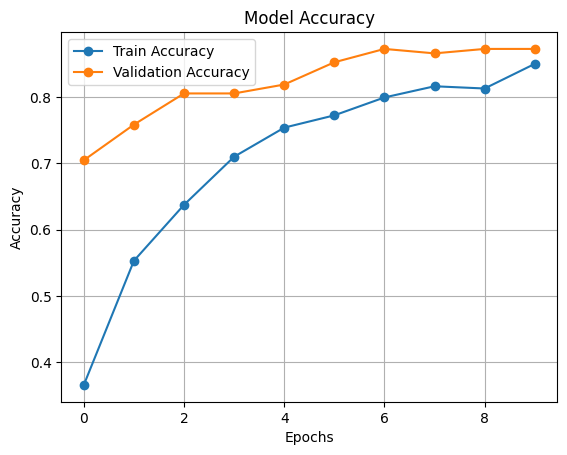

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.grid(True)
plt.show()


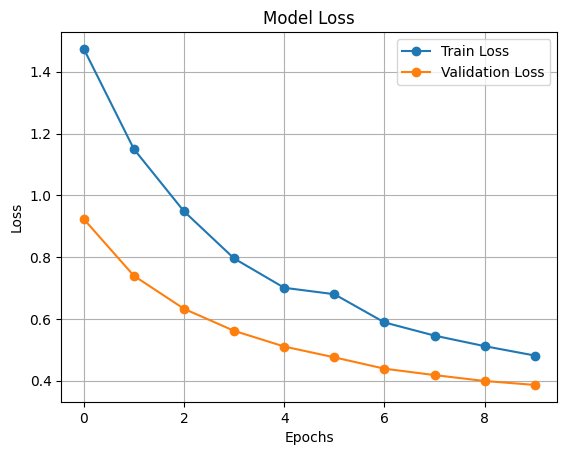

In [ ]:
# Plot Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.grid(True)
plt.show()


In [1]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

# Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


NameError: name 'history' is not defined